# Compute pRF cortical magnification base on pRF parameters 

In [92]:
# Stop warnings
import warnings
warnings.filterwarnings("ignore")

# Import 
import time
import numpy as np
import pandas as pd
from scipy import stats
import neuropythy as ny
import matplotlib.pyplot as plt
import scipy.sparse.csgraph as cs

# Figure imports
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Geodesic distance (mm)

In [2]:
def compute_geodesic_distance(vert_of_interest_idx, adjacency_matrix):
    
    distances = cs.dijkstra(adjacency_matrix, 
                            indices=[vert_of_interest_idx], 
                            directed=False)

    median_distance = np.median(distances)

    return median_distance
    

# Visual distance (dva)

In [14]:
def compute_pRF_distance(vert_of_interest_idx, roi_vertices_hemi_mask, prf_x, prf_y):
    
    dist_array = []
    for vert_num, vert_idx in enumerate(roi_vertices_mask):
        # Acces pRF position
        target_x = prf_x[vert_of_interest_idx]
        target_y = prf_y[vert_of_interest_idx]
        neigboor_x = prf_x[vert_idx]
        neigboor_y = prf_y[vert_idx]
    
        # Compute visual distance
        vert_prf_dist_array_vert = np.sqrt((target_x - neigboor_x)**2 + (target_y - neigboor_y)**2)
        dist_array.append(vert_prf_dist_array_vert)

    # compute the median of visual distance
    vert_prf_dist_array_median = np.median(dist_array)
    
    return vert_prf_dist_array_median
    

# Compute de pRF CM (mm/dva)

## Acces data

In [69]:
# Settings 
subject_id = 111312
hemi = 'lh'
roi = 'V1'

In [4]:
# Load an HCP subject:
sub = ny.hcp_subject(subject_id)

# Get rois boundery
sub = ny.data['hcp_lines'].subjects[subject_id]

In [16]:
# ROI mask
if hemi == 'lh':
    label_roi = sub.lh.prop('visual_area')
elif hemi == 'rh':
    label_roi = sub.rh.prop('visual_area')
roi_vertices_hemi_mask = np.where(label_roi == 1)[0]

In [31]:
# acess pRF parameters (x and y position)
if hemi == 'lh':
    prf_x_hemi = sub.lh.prop('prf_x')
    prf_y_hemi = sub.lh.prop('prf_y')
    prf_ecc_hemi = sub.lh.prop('prf_eccentricity')
    prf_r2 = sub.lh.prop('prf_variance_explained')
elif hemi == 'rh':
    prf_x_hemi = sub.rh.prop('prf_x')
    prf_y_hemi = sub.rh.prop('prf_y')
    prf_ecc_hemi = sub.rh.prop('prf_eccentricity')
    prf_r2 = sub.rh.prop('prf_variance_explained')


In [13]:
# Acces adjacency_matrix
if hemi == 'lh':
    white = sub.lh.surface('white') 
elif hemi == 'rh':
    white = sub.rh.surface('white')

adjacency_matrix = white.adjacency_matrix

## pRF CM computation

In [24]:
start_time = time.time()

prf_dist_list = [] 
geo_dist_list = []

for vert_num, vert_idx in enumerate(roi_vertices_hemi):

    vert_of_interest_idx = vert_idx
    
    # Compute pRF distance
    prf_dist_vert = compute_pRF_distance(vert_of_interest_idx, roi_vertices_hemi_mask, prf_x_hemi, prf_y_hemi)
    prf_dist_list.append(prf_dist_vert)

    # Compute geodesic distance
    geo_dist_vert = compute_geodesic_distance(vert_of_interest_idx, adjacency_matrix)
    geo_dist_list.append(geo_dist_vert)

prf_dist_array = np.array(prf_dist_list)
geo_dist_array = np.array(geo_dist_list)

end_time = time.time()
print(f"Execution time: {end_time - start_time:.2f} seconds")

Execution time: 92.19 seconds


In [26]:
prf_cm_hemi = geo_dist_array / prf_dist_array

In [27]:
prf_cm_hemi

array([62.28280114, 62.31156022, 62.26351912, ..., 36.2889723 ,
       36.35327956, 44.14241708])

# Plotting 

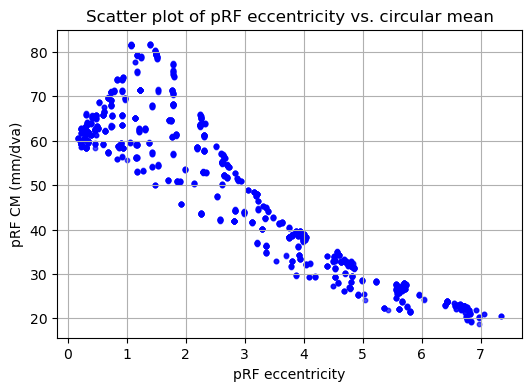

In [46]:
plt.figure(figsize=(6, 4))
plt.scatter(prf_ecc_hemi[roi_vertices_hemi_mask], prf_cm_hemi, s=10, alpha=0.7, c='blue')
plt.xlabel('pRF eccentricity')
plt.ylabel('pRF CM (mm/dva)')
plt.title('Scatter plot of pRF eccentricity vs. circular mean')
plt.grid(True)
plt.show()

## Functions 

In [62]:
def plotly_template(template_specs):
    """
    Define the template for plotly
    Parameters
    ----------
    template_specs : dict
        dictionary contain specific figure settings
    
    Returns
    -------
    fig_template : plotly.graph_objs.layout._template.Template
        Template for plotly figure
    """
    import plotly.graph_objects as go
    fig_template=go.layout.Template()

    # Violin plots
    fig_template.data.violin = [go.Violin(
                                    box_visible=False,
                                    points=False,
                                    # opacity=1,
                                    line_color= "rgba(0, 0, 0, 1)",
                                    line_width=template_specs['plot_width'],
                                    width=0.8,
                                    #marker_symbol='x',
                                    #marker_opacity=1,
                                    hoveron='violins',
                                    meanline_visible=False,
                                    # meanline_color="rgba(0, 0, 0, 1)",
                                    # meanline_width=template_specs['plot_width'],
                                    showlegend=False,
                                    )]

    # Barpolar
    fig_template.data.barpolar = [go.Barpolar(
                                    marker_line_color="rgba(0,0,0,1)",
                                    marker_line_width=template_specs['plot_width'], 
                                    showlegend=False, 
                                    )]
    # Pie plots
    fig_template.data.pie = [go.Pie(textposition=["inside","none"],
                                    # marker_line_color=['rgba(0,0,0,1)','rgba(255,255,255,0)'],
                                    marker_line_width=0,#[template_specs['plot_width'],0],
                                    rotation=0,
                                    direction="clockwise",
                                    hole=0.4,
                                    sort=False,
                                    )]

    # Layout
    fig_template.layout = (go.Layout(# general
                                    font_family=template_specs['font'],
                                    font_size=template_specs['axes_font_size'],
                                    plot_bgcolor=template_specs['bg_col'],

                                    # # x axis
                                    xaxis_visible=True,
                                    xaxis_linewidth=template_specs['axes_width'],
                                    xaxis_color= template_specs['axes_color'],
                                    xaxis_showgrid=False,
                                    xaxis_ticks="outside",
                                    xaxis_ticklen=8,
                                    xaxis_tickwidth = template_specs['axes_width'],
                                    xaxis_title_font_family=template_specs['font'],
                                    xaxis_title_font_size=template_specs['title_font_size'],
                                    xaxis_tickfont_family=template_specs['font'],
                                    xaxis_tickfont_size=template_specs['axes_font_size'],
                                    xaxis_zeroline=False,
                                    xaxis_zerolinecolor=template_specs['axes_color'],
                                    xaxis_zerolinewidth=template_specs['axes_width'],
                                    # xaxis_range=[0,1],
                                    xaxis_hoverformat = '.1f',
                                    
                                    # y axis
                                    yaxis_visible=True,
                                    yaxis_linewidth=template_specs['axes_width'],
                                    yaxis_color= template_specs['axes_color'],
                                    yaxis_showgrid=False,
                                    yaxis_ticks="outside",
                                    yaxis_ticklen=8,
                                    yaxis_tickwidth = template_specs['axes_width'],
                                    yaxis_tickfont_family=template_specs['font'],
                                    yaxis_tickfont_size=template_specs['axes_font_size'],
                                    yaxis_title_font_family=template_specs['font'],
                                    yaxis_title_font_size=template_specs['title_font_size'],
                                    yaxis_zeroline=False,
                                    yaxis_zerolinecolor=template_specs['axes_color'],
                                    yaxis_zerolinewidth=template_specs['axes_width'],
                                    yaxis_hoverformat = '.1f',

                                    # bar polar
                                    polar_radialaxis_visible = False,
                                    polar_radialaxis_showticklabels=False,
                                    polar_radialaxis_ticks='',
                                    polar_angularaxis_visible = False,
                                    polar_angularaxis_showticklabels = False,
                                    polar_angularaxis_ticks = ''
                                    ))

    # Annotations
    fig_template.layout.annotationdefaults = go.layout.Annotation(
                                    font_color=template_specs['axes_color'],
                                    font_family=template_specs['font'],
                                    font_size=template_specs['title_font_size'])

    return fig_template


In [48]:
def weighted_nan_median(data, weights):
    """
    Calculate the weighted median of a data array, ignoring NaN values.

    Parameters:
    data (pd.Series, pd.DataFrame, np.ndarray): Data points, may contain NaN values.
    weights (pd.Series, pd.DataFrame, np.ndarray): Weights corresponding to the data points.

    Returns:
    float: The weighted median of the data points, ignoring NaN values.
           Returns NaN if the cumulative weights are not defined.
    """
    import numpy as np
    import pandas as pd

    # Convert data and weights to pandas Series if they are numpy arrays
    if isinstance(data, np.ndarray):
        data = pd.Series(data)
    if isinstance(weights, np.ndarray):
        weights = pd.Series(weights)
        
    # If data and weights are DataFrames, ensure they have a single column
    if isinstance(data, pd.DataFrame):
        if data.shape[1] != 1:
            raise ValueError("DataFrame data must have exactly one column")
        data = data.iloc[:, 0]
        
    if isinstance(weights, pd.DataFrame):
        if weights.shape[1] != 1:
            raise ValueError("DataFrame weights must have exactly one column")
        weights = weights.iloc[:, 0]

    # Mask NaN values in the data
    mask = ~data.isna()

    # Apply the mask to data and weights
    masked_data = data[mask].reset_index(drop=True)
    masked_weights = weights[mask].reset_index(drop=True)

    # Check if there are no valid data points
    if masked_data.size == 0 or masked_weights.size == 0:
        return np.nan

    # Sort the data and corresponding weights
    masked_data = pd.to_numeric(masked_data, errors='coerce').dropna()
    sorted_indices = np.argsort(masked_data)
    sorted_data = masked_data.iloc[sorted_indices].reset_index(drop=True)
    sorted_weights = masked_weights.iloc[sorted_indices].reset_index(drop=True)

    # Calculate the cumulative sum of weights
    cumulative_weights = np.cumsum(sorted_weights)

    # Check if cumulative_weights is defined and has elements
    if cumulative_weights.size == 0:
        return np.nan

    # Find the median position
    median_weight = cumulative_weights.iloc[-1] / 2.0

    # Find the index where the cumulative weight crosses the median weight
    median_index = np.searchsorted(cumulative_weights, median_weight)

    return sorted_data.iloc[median_index]

In [63]:
def weighted_nan_percentile(data, weights, percentile):
    """
    Calculate the weighted percentile of an array or a pandas Series, ignoring NaN values.

    Parameters:
    data (np.ndarray or pd.Series): Array or pandas Series of data points, may contain NaN values.
    weights (np.ndarray or pd.Series): Array or pandas Series of weights corresponding to the data points.
    percentile (float): Percentile to compute, between 0 and 100.

    Returns:
    float: The weighted percentile of the data points, ignoring NaN values.
           Returns NaN if the cumulative weights are not defined.
    """
    import numpy as np
    import pandas as pd
    
    # Convert pandas Series to numpy array if needed
    if isinstance(data, pd.Series):
        data = data.values
    if isinstance(weights, pd.Series):
        weights = weights.values
    
    # Mask NaN values in the data
    mask = ~np.isnan(data)
    
    # Apply the mask to data and weights
    masked_data = data[mask]
    masked_weights = weights[mask]
    
    # Check if there are no valid data points
    if masked_data.size == 0 or masked_weights.size == 0:
        return np.nan
    
    # Sort the data and corresponding weights
    sorted_indices = np.argsort(masked_data)
    sorted_data = masked_data[sorted_indices]
    sorted_weights = masked_weights[sorted_indices]
    
    # Calculate the cumulative sum of weights
    cumulative_weights = np.cumsum(sorted_weights)
    
    # Check if cumulative_weights is defined and has elements
    if cumulative_weights.size == 0:
        return np.nan
    
    # Calculate the percentile weight
    percentile_weight = percentile / 100.0 * cumulative_weights[-1]
    
    # Find the index where the cumulative weight crosses the percentile weight
    percentile_index = np.searchsorted(cumulative_weights, percentile_weight)
    
    return float(sorted_data[percentile_index])

In [77]:
def weighted_regression(x_reg, y_reg, weight_reg, model):
    """
    Function to compute regression parameter weighted by a matrix (e.g. r2 value),
    where the regression model is y = 1/(cx) + d.

    Parameters
    ----------
    x_reg : array (1D)
        x values to regress
    y_reg : array
        y values to regress
    weight_reg : array (1D) 
        weight values (0 to 1) for weighted regression
    model : str
        Type of regression model, either 'pcm' for the original model or 'linear' for a linear model.

    Returns
    -------
    coef_reg : float or array
        regression coefficient(s)
    intercept_reg : float or str
        regression intercept or a string indicating no intercept (for linear model)
    """

    import numpy as np
    from scipy.optimize import curve_fit
    from sklearn import linear_model
    
    
    
    x_reg = np.array(x_reg)
    y_reg = np.array(y_reg)
    
    weight_reg = np.array(weight_reg)

    # Filter out NaN values
    x_reg_nan = x_reg[(~np.isnan(x_reg) & ~np.isnan(y_reg))]
    y_reg_nan = y_reg[(~np.isnan(x_reg) & ~np.isnan(y_reg))]
    weight_reg_nan = weight_reg[~np.isnan(weight_reg)]
    
    if model == 'pcm':
        # Define the model function
        def model_function(x, c, d):
            return 1 / (c * x + d)

        if weight_reg_nan.size >= 2:
            # Perform curve fitting
            params, _ = curve_fit(model_function, x_reg_nan, y_reg_nan, sigma=weight_reg_nan, maxfev=10000)
            c, d = params
        else:
            c, d = np.nan, np.nan
        return c, d

    elif model == 'linear':
        if weight_reg_nan.size >= 2:
            regr = linear_model.LinearRegression()
            
            # Filter out NaN values
            x_reg_nan = x_reg_nan.reshape(-1, 1)
            y_reg_nan = y_reg_nan.reshape(-1, 1)
            
            regr.fit(x_reg_nan, y_reg_nan, sample_weight=weight_reg_nan)
            coef_reg, intercept_reg = regr.coef_[0][0], regr.intercept_[0]
        else: 
            coef_reg, intercept_reg = np.nan, np.nan
        return coef_reg, intercept_reg
    else:
        raise ValueError("Invalid model type. Supported models are 'pcm' and 'linear'.")


In [109]:
def prf_ecc_pcm_plot(df_ecc_pcm, fig_width, fig_height, rois, roi_colors, plot_groups, max_ecc):
    """
    Make scatter plot for relationship between eccentricity and pCM

    Parameters
    ----------
    df_ecc_pcm : dataframe for the plot
    fig_width : figure width in pixels
    fig_height : figure height in pixels
    rois : list of rois
    roi_colors : dictionary with keys as roi and value correspondig rgb color
    plot_groups : groups of roi to plot together
    max_ecc : maximum eccentricity
    
    Returns
    -------
    fig : eccentricy as a function of pcm plot
    """

    
    # General figure settings
    template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                          axes_width=2,
                          axes_font_size=15,
                          bg_col="rgba(255, 255, 255, 1)",
                          font='Arial',
                          title_font_size=15,
                          plot_width=1.5)
    
    # General figure settings
    fig_template = plotly_template(template_specs)

    # General settings
    rows, cols = 1, len(plot_groups)
    fig = make_subplots(rows=rows, cols=cols, print_grid=False)
    
    for l, line_label in enumerate(plot_groups):
        for j, roi in enumerate(line_label):

            # Parametring colors
            roi_color = roi_colors[roi]
            roi_color_opac = f"rgba{roi_color[3:-1]}, 0.15)"
            
            # Get data
            df = df_ecc_pcm.loc[(df_ecc_pcm.roi == roi)]
            ecc_median = np.array(df.prf_ecc_bins)
            pcm_median = np.array(df.prf_pcm_bins_median)
            r2_median = np.array(df.prf_loo_r2_bins_median)
            pcm_upper_bound = np.array(df.prf_pcm_bins_ci_upper_bound)
            pcm_lower_bound = np.array(df.prf_pcm_bins_ci_lower_bound)
            
            # Linear regression
            slope, intercept = weighted_regression(ecc_median, pcm_median, r2_median, model='pcm')
            
            slope_upper, intercept_upper = weighted_regression(ecc_median[~np.isnan(pcm_upper_bound)], 
                                                               pcm_upper_bound[~np.isnan(pcm_upper_bound)], 
                                                               r2_median[~np.isnan(pcm_upper_bound)], 
                                                               model='pcm')
            
            slope_lower, intercept_lower = weighted_regression(ecc_median[~np.isnan(pcm_lower_bound)], 
                                                               pcm_lower_bound[~np.isnan(pcm_lower_bound)], 
                                                               r2_median[~np.isnan(pcm_lower_bound)], 
                                                               model='pcm')

            line_x = np.linspace(ecc_median[0], ecc_median[-1], 50)
            line = 1 / (slope * line_x + intercept)
            line_upper = 1 / (slope_upper * line_x + intercept_upper)
            line_lower = 1 / (slope_lower * line_x + intercept_lower)

            from sklearn.metrics import r2_score
            
            # Filtrer les NaN dans les données
            valid_idx = ~np.isnan(pcm_median) & ~np.isnan(ecc_median)
            x_valid = ecc_median[valid_idx]
            y_valid = pcm_median[valid_idx]
            
            # Générer les prédictions avec ton modèle (y = 1/(cx + d))
            y_pred = 1 / (slope * x_valid + intercept)
            
            # Calculer R²
            r2 = r2_score(y_valid, y_pred)

            fig.add_trace(go.Scatter(x=line_x, 
                                     y=line, 
                                     mode='lines', 
                                     name=roi, 
                                     legendgroup=roi, 
                                     line=dict(color=roi_color, width=3), 
                                     showlegend=False), 
                          row=1, col=l+1)

            # Error area
            fig.add_trace(go.Scatter(x=np.concatenate([line_x, line_x[::-1]]),
                                      y=np.concatenate([list(line_upper), list(line_lower[::-1])]), 
                                      mode='lines', fill='toself', fillcolor=roi_color_opac, 
                                      line=dict(color=roi_color_opac, width=0), showlegend=False), 
                          row=1, col=l+1)

            # Markers
            fig.add_trace(go.Scatter(x=ecc_median, 
                                     y=pcm_median, 
                                     mode='markers', 
                                     error_y=dict(type='data', 
                                                  array=pcm_upper_bound - pcm_median, 
                                                  arrayminus=pcm_median - pcm_lower_bound,
                                                  visible=True, 
                                                  thickness=3, 
                                                  width=0, 
                                                  color=roi_color),
                                     marker=dict(color=roi_color, 
                                                 symbol='square',
                                                 size=8, line=dict(color=roi_color,
                                                                   width=3)), 
                                     showlegend=False), 
                          row=1, col=l + 1)
            
            # Add legend
            annotation = go.layout.Annotation(x=5, y=80, text='{}, R2={:.2f}'.format(roi,r2), xanchor='left',
                                              showarrow=False, font_color=roi_color, 
                                              font_family=template_specs['font'],
                                              font_size=template_specs['axes_font_size'],
                                             )
            fig.add_annotation(annotation, row=1, col=l+1)

        # Set axis titles only for the left-most column and bottom-most row
        fig.update_yaxes(title_text='pRF cortical magn. (mm/dva)', row=1, col=1)
        fig.update_xaxes(title_text='pRF eccentricity (dva)', range=[0, max_ecc], showline=True, row=1, col=l+1)
        fig.update_yaxes(range=[0, 80], showline=True)
        fig.update_layout(height=fig_height, width=fig_width, showlegend=False, template=fig_template,
                         margin_l=100, margin_r=50, margin_t=50, margin_b=100)
        
    return fig

## Make DF

In [35]:
prf_ecc_hemi.shape

(122891,)

In [36]:
prf_cm_hemi.shape

(1807,)

In [37]:
data_pcm = pd.DataFrame({'prf_ecc': prf_ecc_hemi[roi_vertices_hemi_mask],
                         'pcm_median': prf_cm_hemi,
                         'prf_loo_r2':prf_r2[roi_vertices_hemi_mask], 
                         'roi':[roi]*prf_cm_hemi.shape[0]
                        })

In [83]:
data= data_pcm
num_ecc_pcm_bins = 6
max_ecc = 8
rois = ['V1']
ecc_bins = np.concatenate(([0],np.linspace(0.26, 1, num_ecc_pcm_bins)**2 * max_ecc))
for num_roi, roi in enumerate(rois):
    df_roi = data_pcm.loc[(data.roi == roi)]
    df_bins = df_roi.groupby(pd.cut(df_roi['prf_ecc'], bins=ecc_bins))
    df_ecc_pcm_bin = pd.DataFrame()
    df_ecc_pcm_bin['roi'] = [roi]*num_ecc_pcm_bins
    df_ecc_pcm_bin['num_bins'] = np.arange(num_ecc_pcm_bins)
    df_ecc_pcm_bin['prf_ecc_bins'] = df_bins.apply(lambda x: weighted_nan_median(x['prf_ecc'].values, x['prf_loo_r2'].values)).values
    df_ecc_pcm_bin['prf_pcm_bins_median'] = df_bins.apply(lambda x: weighted_nan_median(x['pcm_median'].values, x['prf_loo_r2'].values)).values
    df_ecc_pcm_bin['prf_loo_r2_bins_median'] = np.array(df_bins['prf_loo_r2'].median())
    df_ecc_pcm_bin['prf_pcm_bins_ci_upper_bound'] = df_bins.apply(lambda x: weighted_nan_percentile(x['pcm_median'].values, x['prf_loo_r2'].values, 75)).values
    df_ecc_pcm_bin['prf_pcm_bins_ci_lower_bound'] = df_bins.apply(lambda x: weighted_nan_percentile(x['pcm_median'].values, x['prf_loo_r2'].values, 25)).values
    if num_roi == 0: df_ecc_pcm_bins = df_ecc_pcm_bin
    else: df_ecc_pcm_bins = pd.concat([df_ecc_pcm_bins, df_ecc_pcm_bin])  

df_ecc_pcm = df_ecc_pcm_bins

In [89]:
df_ecc_pcm

,roi,num_bins,prf_ecc_bins,prf_pcm_bins_median,prf_loo_r2_bins_median,prf_pcm_bins_ci_upper_bound,prf_pcm_bins_ci_lower_bound
0,V1,0,0.346305,61.874333,0.344225,62.805421,60.273913
1,V1,1,0.941754,65.076903,0.507617,70.984578,59.168427
2,V1,2,1.833004,61.426301,0.617270,68.178928,54.210124
3,V1,3,3.215048,42.203496,0.668183,50.176400,38.600368
4,V1,4,4.784975,29.281066,0.619467,32.765306,26.673288
5,V1,5,6.675991,22.718648,0.566523,23.088247,21.473807


In [97]:
df = df_ecc_pcm

ecc_median = np.array(df.prf_ecc_bins)
pcm_median = np.array(df.prf_pcm_bins_median)
r2_median = np.array(df.prf_loo_r2_bins_median)

slope, intercept = weighted_regression(ecc_median, pcm_median, r2_median, model='pcm')
pred_pcm_roi = 1 / (df.prf_ecc_bins * slope + intercept) 


results = stats.linregress(x=pred_pcm_roi, y=df.prf_pcm_bins_median, alternative='greater')

rvalue = results.rvalue

In [98]:
rvalue

0.9406318523365845

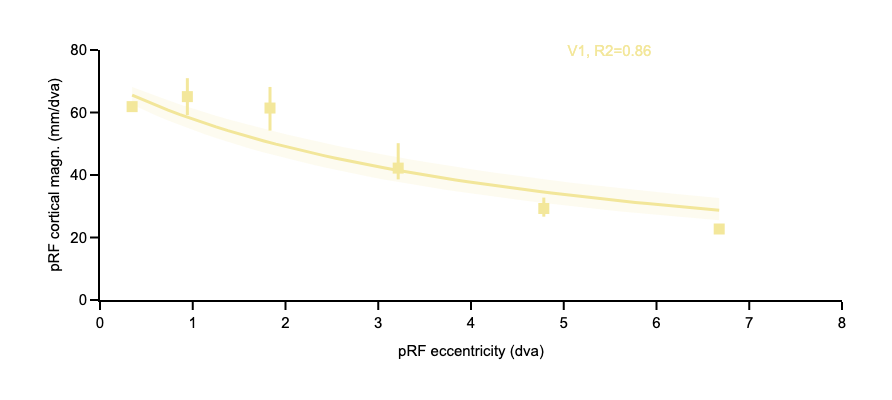

In [110]:
# Figure settings
roi_colors = {'V1': 'rgb(243, 231, 155)', 
              'V2': 'rgb(250, 196, 132)', 
              'V3': 'rgb(248, 160, 126)', 
              'V3AB': 'rgb(235, 127, 134)', 
              'LO': 'rgb(150, 0, 90)',  
              'VO': 'rgb(0, 0, 200)', 
              'hMT+': 'rgb(0, 25, 255)', 
              'iIPS': 'rgb(0, 152, 255)', 
              'sIPS': 'rgb(44, 255, 150)', 
              'iPCS': 'rgb(151, 255, 0)', 
              'sPCS': 'rgb(255, 234, 0)', 
              'mPCS': 'rgb(255, 111, 0)'}



# Template settings
template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                      axes_width=2,
                      axes_font_size=15,
                      bg_col="rgba(255, 255, 255, 1)",
                      font='Arial',
                      title_font_size=15,
                      plot_width=1.5)
fig_template = plotly_template(template_specs)
standoff = 8

rois = ['V1']

fig = prf_ecc_pcm_plot(df_ecc_pcm=df_ecc_pcm, fig_width=400, fig_height=400, 
                            rois=['V1'], roi_colors=roi_colors,
                            plot_groups=[['V1']], max_ecc=max_ecc)

fig.show()


In [71]:
roi

'V1'